# High Speed

Classical FMCW chirp processing computes the speed over multiple chirps.

However in the case where the range bin changes within a chirp, it is also possible to measure the speed via rate of range bin change.

The following is a simple illustration leveraging a STFT for illustration purposes

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/matt-chv/mmWrt/blob/main/docs/High-Speed.ipynb)

In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
from os.path import abspath, basename, join, pardir
import datetime

# hack to handle if running from git cloned folder or stand alone (like Google Colab)
cw = basename(abspath(join(".")))
dp = abspath(join(".",pardir))
if cw=="docs" and basename(dp) == "mmWrt":
    # running from cloned folder
    print("running from git folder, using local path (latest) mmWrt code", dp)
    sys.path.insert(0, dp)
else:
    print("running standalone, need to ensure mmWrt is installed")
    !{sys.executable} -m pip install mmWrt

from os.path import abspath, join, pardir
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from numpy import where, expand_dims
from numpy import complex128 as complex

# uncomment below if the notebook is launched from project's root folder
# dp = abspath(join(".",pardir))
# sys.path.insert(0, dp)


from mmWrt.Raytracing import rt_points  # noqa: E402
from mmWrt.Scene import Radar, Transmitter, Receiver, Target  # noqa: E402
from mmWrt import RadarSignalProcessing as rsp  # noqa: E402
from mmWrt import __version__ as mmWrt_ver
print(mmWrt_ver)
print(datetime.datetime.now())

running from git folder, using local path (latest) mmWrt code c:\git\mmWrt
0.0.9
2024-12-06 09:26:35.733645


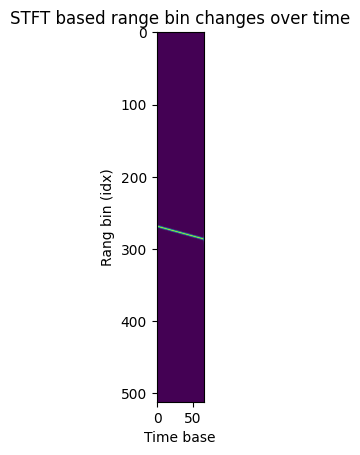

In [39]:
from scipy.fft import fft, fft2
from scipy.signal import stft

c = 3e8

debug_ON = False
test = 0
NC=1
n=16
NA=512*n*2
fs0 = 10e5*n
slope0 = 2e12
tic0 = 1.2e-3
raytracing_opt = {"logging_level":10}
radar = Radar(transmitter=Transmitter(bw=4e9, slope=slope0,
                                      t_inter_chirp=tic0,
                                      chirps_count=NC),
              receiver=Receiver(fs=fs0, n_adc=NA, max_adc_buffer_size=NA*2,
                                max_fs=fs0*2,
                                debug=debug_ON), debug=debug_ON)

x1, v1 = 5, 10000*2
target1 = Target(xt=lambda t: v1*t+x1)

targets = [target1]

bb = rt_points(radar, targets,
               datatype=complex, debug=debug_ON,
               raytracing_opt=raytracing_opt)

cube = bb["adc_cube"][0,0,0,0,:]

seg_n = 512
# nperseg: Length of each segment
# noverlapint: Number of points to overlap between segments. If None, noverlap = nperseg // 2
# return_onesidedbool, optional - If True, return a one-sided spectrum for real data.
_, _, fft_st = stft(cube, nperseg=seg_n, return_onesided=False)
plt.title("STFT based range bin changes over time")
plt.xlabel("Time base")
plt.ylabel("Rang bin (idx)")
plt.imshow(abs(fft_st[:,:]))

## compute speed after STFT

In [42]:
from scipy.signal import find_peaks
# find the range bin where target is at the begining of STFT
peak_at_start = find_peaks(abs(fft_st[:,0]))[0][0]
# find the range bin where the target is at the end of STFT
peak_at_end = find_peaks(abs(fft_st[:,-1]))[0][0]

# speed = Delta D/Delta T

# Range bin resolution from samples
R_bin_fft = fs0*c/2/slope0/NA
# Range bin resolution for STFT is scaled up by nperseg
R_bin_stft = R_bin_fft*NA/seg_n
# compute the chirp time, which is also the divider for the speed
Tc = NA*1/fs0
# The target distance grows 2x (there and back) so speed needs to be divided by 2
print("speed estimate", (peak_at_end-peak_at_start)*R_bin_stft/Tc/2)


speed estimate 20599.365234375
